# Seq2Seq 기반 챗봇 만들기

> 2. 모델 학습

In [19]:
# 모듈 불러오기
from tensorflow.keras.layers import Input, Dense, Embedding
from tensorflow.keras.layers import LSTM, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import pickle

from IPython.display import SVG
from keras.utils import model_to_dot

In [20]:
# 경로 설정
root_path = "/content/drive/My Drive/멀티캠퍼스/[혁신성장] 인공지능 자연어처리 기반/[강의]/조성현 강사님"
data_path = f"{root_path}/dataset"
chatbot_path = f"{root_path}/Seq2Seq-Chatbot"

## 데이터 로드

In [21]:
# 어휘집 사전
with open(f"{data_path}/6-1.vocabulary.pickle", 'rb') as f:
    word2idx, idx2word = pickle.load(f)

In [22]:
# 학습 데이터: 인코딩, 디코딩 입력, 디코딩 출력
with open(f"{data_path}/6-1.train_data.pickle", 'rb') as f:
    X_train_E, X_train_D, y_train_D = pickle.load(f)

# 테스트 데이터: 인코딩, 디코딩 입력, 디코딩 출력
with open(f"{data_path}/6-1.eval_data.pickle", 'rb') as f:
    X_test_E, X_test_D, y_test_D = pickle.load(f)

## 모델 구성

In [23]:
# 모델 파라미터 설정
VOCAB_SIZE = len(idx2word)
EMB_SIZE = int(input('임베딩 출력 차원 설정: '))
LSTM_HIDDEN = int(input('LSTM 은닉 노드 수 설정: '))
MODEL_PATH = f"{chatbot_path}/Seq2Seq.h5"

임베딩 출력 차원 설정: 128
LSTM 은닉 노드 수 설정: 128


In [24]:
# 세션 클리어
K.clear_session()

# 공통 임베딩 레이어
wordEmbedding = Embedding(input_dim=VOCAB_SIZE, output_dim=EMB_SIZE)

In [25]:
# Encoder 네트워크 구성
X_input_E = Input(batch_shape=(None, X_train_E.shape[1]))
X_embed_E = wordEmbedding(X_input_E)
X_lstm1_E = LSTM(LSTM_HIDDEN, return_sequences=True, return_state=True)
X_lstm2_E = LSTM(LSTM_HIDDEN, return_state=True)
ey1, eh1, ec1 = X_lstm1_E(X_embed_E)
_, eh2, ec2 = X_lstm2_E(ey1) # 1층의 출력을 받는다

In [26]:
# Decoder 네트워크 구성
X_input_D = Input(batch_shape=(None, X_train_D.shape[1]))
X_embed_D = wordEmbedding(X_input_D)
X_lstm1_D = LSTM(LSTM_HIDDEN, return_sequences=True, return_state=True)
X_lstm2_D = LSTM(LSTM_HIDDEN, return_sequences=True, return_state=True)
dy1, _, _ = X_lstm1_D(X_embed_D, initial_state=[eh1, ec1]) # 초기 상태 설정
dy2, _, _ = X_lstm2_D(dy1, initial_state=[eh2, ec2]) # 초기 상태 설정

In [27]:
# 출력 네트워크
y_output = TimeDistributed(Dense(VOCAB_SIZE, activation='softmax')) # 시간 분배
y_output = y_output(dy2)

========== 모델 전체 구조 확인 ==========
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 10, 128)      2650240     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 10, 128), (N 

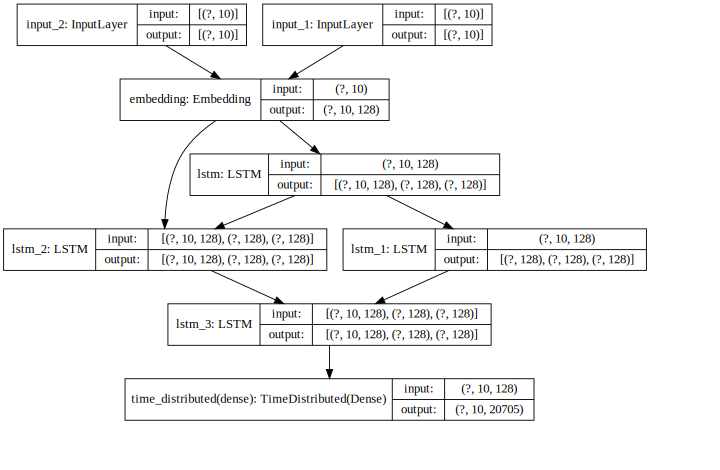

In [28]:
# 모델 구성
model = Model([X_input_E, X_input_D], y_output)
model.compile(optimizer=Adam(lr=0.001),
              loss='sparse_categorical_crossentropy')
print("========== 모델 전체 구조 확인 ==========")
print(model.summary())
SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

## 학습

In [ ]:
LOAD_MODEL = False

if LOAD_MODEL :
    model.load_weights(MODEL_PATH)

# teacher forcing 학습
hist = model.fit([X_train_E, X_train_D], y_train_D,
                 batch_size=300,
                 epochs=500,
                 shuffle=True,
                 validation_data=([X_test_E, X_test_D], y_test_D))

Epoch 1/500
36/36 [==============================] - 16s 453ms/step - loss: 7.7641 - val_loss: 4.6962
Epoch 2/500
36/36 [==============================] - 15s 410ms/step - loss: 3.9470 - val_loss: 3.8038
Epoch 3/500
36/36 [==============================] - 14s 396ms/step - loss: 3.6484 - val_loss: 3.6988
Epoch 4/500
36/36 [==============================] - 14s 401ms/step - loss: 3.5489 - val_loss: 3.6492
Epoch 5/500
36/36 [==============================] - 14s 403ms/step - loss: 3.4539 - val_loss: 3.5810
Epoch 6/500
36/36 [==============================] - 14s 389ms/step - loss: 3.3504 - val_loss: 3.5436
Epoch 7/500
36/36 [==============================] - 14s 394ms/step - loss: 3.2722 - val_loss: 3.5453
Epoch 8/500
36/36 [==============================] - 14s 400ms/step - loss: 3.2111 - val_loss: 3.5317
Epoch 9/500
36/36 [==============================] - 14s 395ms/step - loss: 3.1524 - val_loss: 3.4904
Epoch 10/500
36/36 [==============================] - 14s 383ms/step - loss: 3.086

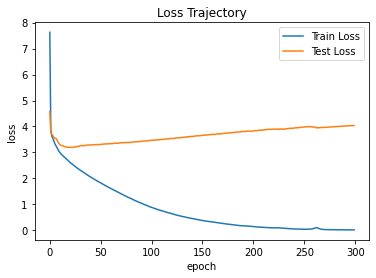

In [16]:
# # loss 시각화 : 첫 번째 학습
# plt.plot(hist.history['loss'], label='Train Loss')
# plt.plot(hist.history['val_loss'], label='Test Loss')
# plt.legend()
# plt.title('Loss Trajectory')
# plt.xlabel('epoch')
# plt.ylabel('loss')
# plt.show()

In [ ]:
# loss 시각화 : 두 번째 학습(500)
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Test Loss')
plt.legend()
plt.title('Loss Trajectory')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [17]:
# 학습 결과 저장
model.save_weights(MODEL_PATH)